In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing Required Libraries

We start by installing the required deep learning libraries for object detection and segmentation:

- `ultralytics`: For using YOLOv13 models.
- `segment_anything`: Meta AI's segmentation model, installed in editable mode.


In [3]:
!pip install ultralytics
%cd /content/drive/MyDrive/Colab Notebooks/segment_anything
!pip install -e.

/content/drive/MyDrive/Colab Notebooks/segment_anything
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/segment_anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment_anything
    Found existing installation: segment_anything 1.0
    Uninstalling segment_anything-1.0:
      Successfully uninstalled segment_anything-1.0
  Running setup.py develop for segment_anything


## 🧠 Brain Tumor Classification using ResNet-18

This notebook performs **brain tumor type classification** using a pretrained **ResNet-18** model. The model classifies MRI brain images into one of four categories:

- **Glioma Tumor**
- **Meningioma Tumor**
- **Pituitary Tumor**
- **No Tumor**

The model was trained using PyTorch, and we use an image transformation pipeline for input preprocessing. Let's walk through the inference steps on a sample image.


In [11]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models

# Input image path
image_path = "/content/drive/MyDrive/tumor_samples/giloma/Te-glTr_0007_jpg.rf.9221b49ad766c4463f468b8b851ff4e6.jpg"
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load ResNet-18 classification model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/tumor-1/best_resnet_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Class labels
class_names = ["Glioma Tumor", "Meningioma Tumor", "No Tumor", "Pituitary Tumor"]

# Classification
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
    label = class_names[predicted_class]
    print(f" Predicted Class: {label}")
    return label, image

# Run classification
predicted_label, image_pil = classify_image(image_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Predicted Class: Glioma Tumor


## 🧠 Tumor Localization using YOLOv12

If the classification model predicts a tumor (i.e., not "No Tumor"), we run **YOLOv12** for object detection to **locate the tumor** in the brain MRI image.

- The YOLOv12 model is pre-trained on annotated brain tumor datasets.
- If no bounding box is detected, a fallback message is shown.
- If detected, the bounding box coordinates are stored for further processing (e.g., segmentation using SAM).


In [12]:
from ultralytics import YOLO
import cv2
import numpy as np

# YOLO detection only if tumor exists
run_sam = False
if predicted_label != "No Tumor":
    print("🔎 Running YOLO Detection...")
    image_pil.save("/tmp/uploaded_image.jpg")
    input_img = cv2.imread("/tmp/uploaded_image.jpg")
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    # Load YOLO model
    yolo_model = YOLO("/content/drive/MyDrive/brain-tumor/runs/detect/train/weights/best.pt")
    results = yolo_model.predict(source=input_img, conf=0.25)

    if not results or results[0].boxes.xyxy.numel() == 0:
        print("SOORY FOR THIS MODEL CANNOT ABLE DETECT THE TUMOR.")
    else:
        print("Tumor detected by YOLO.")
        bbox = results[0].boxes.xyxy.tolist()[0]
        run_sam = True
else:
    print(" No tumor detected. Detection & segmentation skipped.")


🔎 Running YOLO Detection...

0: 640x640 1 Glioma, 30.3ms
Speed: 2.5ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Tumor detected by YOLO.


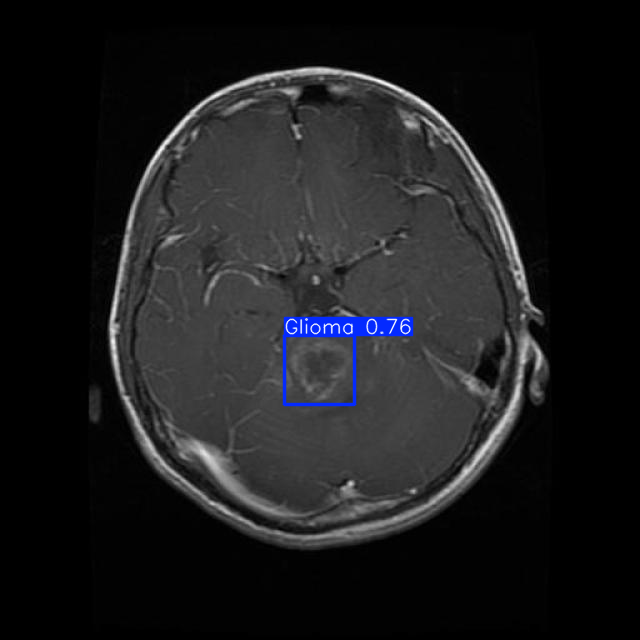

In [13]:
results[0].show()

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Glioma', 1: 'Meningioma', 2: 'Pituitary tumor'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
    

## 🧬 Tumor Segmentation using SAM (Segment Anything Model)

After tumor detection using YOLO, we apply the **Segment Anything Model (SAM)** to extract the **precise tumor region**.

- **Input:** Tumor bounding box from YOLO detection.
- **Output:** Binary mask of the tumor region.
- **Model:** SAM with ViT-H backbone, loaded from a local checkpoint.
- **Visualization:** Displays original image, YOLO detection, SAM mask, and tumor overlay.

This step highlights the tumor's exact region within the brain MRI scan, which is crucial for medical diagnosis and further analysis.


In [14]:
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

if run_sam:
    print("Running SAM segmentation...")
    sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/sam_vit_h.pth"
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to("cpu")
    predictor = SamPredictor(sam)
    predictor.set_image(input_img)

    masks, _, _ = predictor.predict(box=np.array(bbox)[None, :], multimask_output=False)
    mask = masks[0]

    # Visualization
    x1, y1, x2, y2 = map(int, bbox)
    detected_image = input_img.copy()
    segmented_image = input_img.copy()
    cv2.rectangle(detected_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    segmented_image[mask > 0] = [255, 0, 0]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_img)
    axes[0].set_title("Input Image")
    axes[1].imshow(detected_image)
    axes[1].set_title("Detected Tumor (YOLO)")
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title("Tumor Mask (SAM)")
    axes[3].imshow(segmented_image)
    axes[3].set_title("Segmented Tumor (Overlay)")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    print("✅ Segmentation completed.")


Running SAM segmentation...

0: 640x640 1 Meningioma, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
✅ Segmentation completed.


### 📲 Gradio for Model Deployment

Gradio is a Python library that creates interactive web apps for ML models.  
It supports inputs like images, text, and audio with real-time outputs.  
Ideal for showcasing, testing, or sharing models with minimal code.  
Perfect for research demos, classroom use, and final-year projects.


In [7]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


### 🧠 Brain Tumor Analysis & Diagnosis Web App
This app performs brain tumor classification, detection, and segmentation from MRI images using deep learning.
It uses a ResNet-18 model for tumor classification, YOLOv12 for tumor detection, and SAM (Segment Anything Model) for precise segmentation.
Users can upload MRI scans and instantly get visual outputs showing detected tumor regions and segmentation masks.
The entire workflow is wrapped in an interactive Gradio web interface, perfect for research demonstrations and clinical use.

In [8]:


from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from ultralytics import YOLO
import numpy as np
import gradio as gr
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load ResNet-18 classification model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/tumor-1/best_resnet_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load YOLOv8 model
yolo_model = YOLO("/content/drive/MyDrive/brain-tumor/runs/detect/train/weights/best.pt")

# Load SAM
sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/sam_vit_h.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to("cpu")
predictor = SamPredictor(sam)

# Class labels
class_names = ["Glioma Tumor", "Meningioma Tumor", "No Tumor", "Pituitary Tumor"]

# Main prediction function
def classify_detect_segment(image):
    tmp_path = "/tmp/uploaded_image.jpg"
    image.save(tmp_path)

    # Classification
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
    label = class_names[predicted_class]

    # Read input image
    input_img = cv2.imread(tmp_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    segmented_image = input_img.copy()

    # Detection and segmentation if tumor exists
    if label != "No Tumor":
        results = yolo_model.predict(source=input_img, conf=0.25)
        if results and results[0].boxes.xyxy.numel() > 0:
            bbox = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = bbox

            # Draw detection box
            detected_image = input_img.copy()
            cv2.rectangle(detected_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Run SAM segmentation
            predictor.set_image(input_img)
            masks, _, _ = predictor.predict(box=bbox[None, :], multimask_output=False)
            mask = masks[0]
            segmented_image[mask > 0] = [255, 0, 0]
        else:
            detected_image = input_img
            segmented_image = input_img
    else:
        detected_image = input_img

    # Resize for Gradio UI
    return (
        cv2.resize(detected_image, (512, 512)),
        cv2.resize(segmented_image, (512, 512)),
        label
    )

# Gradio UI
gr.Interface(
    fn=classify_detect_segment,
    inputs=gr.Image(type="pil", label="Upload Brain MRI"),
    outputs=[

        gr.Image(type="numpy", label="Detection Result"),
        gr.Image(type="numpy", label="SAM Segmented Tumor"),
        gr.Textbox(label="Predicted Tumor Class")
    ],
    title="Brain Tumor Analysis & Diagnosis",
    description="Upload a brain MRI image. This app classifies the tumor, detects it using YOLOv12, and segments it using SAM.",
).launch(share=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5d6fb1d495e9c1a6be.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
